In [1]:
from __future__ import print_function, division
import pandas as pd
import os
import requests
import json
import urllib
import shapely
from fiona.crs import from_epsg
import scipy as sp
from scipy import stats
import geopandas as gpd
import pylab as pl
import io
import pylab as pl
import plotly.plotly as py
import plotly.graph_objs as go

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Trees in NYC

In [27]:
trees= pd.read_csv("https://data.cityofnewyork.us/api/views/5rq2-4hqu/rows.csv?accessType=DOWNLOAD")

In [28]:
trees.describe()

,tree_id,block_id,tree_dbh,stump_diam,zipcode,cb_num,borocode,cncldist,st_assem,st_senate,boro_ct,Latitude,longitude,x_sp,y_sp
count,528984.000000,528984.000000,528984.000000,528984.000000,528983.000000,528983.000000,528983.000000,528983.000000,528983.000000,528983.000000,5.289830e+05,528983.000000,528983.000000,5.289830e+05,528983.000000
mean,443100.020110,324334.221182,11.556147,0.453214,10937.848515,353.469420,3.455614,30.890335,50.313195,20.324782,3.503945e+06,40.696950,-73.921393,1.006017e+06,193230.767136
std,168528.141957,111064.154348,8.945698,3.403157,623.025086,110.393686,1.115571,14.034707,19.148126,7.442015,1.121882e+06,0.091960,0.129349,3.588603e+04,33503.397421
min,3.000000,100002.000000,0.000000,0.000000,83.000000,101.000000,1.000000,1.000000,23.000000,10.000000,1.000201e+06,40.498466,-74.254965,9.133493e+05,120973.792223
25%,309236.750000,225877.000000,4.000000,0.000000,10454.000000,305.000000,3.000000,19.000000,32.000000,14.000000,3.020800e+06,40.626698,-73.980518,9.896523e+05,167609.282942
50%,447194.500000,323874.000000,10.000000,0.000000,11215.000000,404.000000,4.000000,30.000000,50.000000,20.000000,4.018700e+06,40.692697,-73.904474,1.010713e+06,191688.679008
75%,586635.250000,407088.000000,16.000000,0.000000,11367.000000,412.000000,4.000000,45.000000,63.000000,24.000000,4.115500e+06,40.759742,-73.825009,1.032732e+06,216114.949873
max,722694.000000,999999.000000,450.000000,140.000000,11697.000000,503.000000,5.000000,51.000000,87.000000,36.000000,5.032300e+06,40.912807,-73.700488,1.067248e+06,271853.443547


In [29]:
trees.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_assem,st_senate,nta,nta_name,boro_ct,state,Latitude,longitude,x_sp,y_sp
0,08/27/2015,180683.0,348711.0,POINT (-73.84421521958048 40.723091773924274),3.0,0.0,OnCurb,Alive,Fair,Acer rubrum,...,28.0,16.0,QN17,Forest Hills,4073900.0,New York,40.723092,-73.844215,1.027431e+06,202756.768749
1,09/03/2015,200540.0,315986.0,POINT (-73.81867945834878 40.79411066708779),21.0,0.0,OnCurb,Alive,Fair,Quercus palustris,...,27.0,11.0,QN49,Whitestone,4097300.0,New York,40.794111,-73.818679,1.034456e+06,228644.837379
2,09/05/2015,204026.0,218365.0,POINT (-73.93660770459083 40.717580740099116),3.0,0.0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,50.0,18.0,BK90,East Williamsburg,3044900.0,New York,40.717581,-73.936608,1.001823e+06,200716.891267
3,09/05/2015,204337.0,217969.0,POINT (-73.93445615919741 40.713537494833226),10.0,0.0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,53.0,18.0,BK90,East Williamsburg,3044900.0,New York,40.713537,-73.934456,1.002420e+06,199244.253136
4,08/30/2015,189565.0,223043.0,POINT (-73.97597938483258 40.66677775537875),21.0,0.0,OnCurb,Alive,Good,Tilia americana,...,44.0,21.0,BK37,Park Slope-Gowanus,3016500.0,New York,40.666778,-73.975979,9.909138e+05,182202.425999


In [30]:
trees.borocode.unique()

array([ 4.,  3.,  1.,  5.,  2., nan])

In [31]:
manTrees = trees[trees['borocode'] == 1]
manTrees.describe()

,tree_id,block_id,tree_dbh,stump_diam,zipcode,cb_num,borocode,cncldist,st_assem,st_senate,boro_ct,Latitude,longitude,x_sp,y_sp
count,34607.000000,34607.000000,34607.000000,34607.00000,34607.000000,34607.000000,34607.0,34607.000000,34607.000000,34607.000000,3.460700e+04,34607.000000,34607.000000,3.460700e+04,34607.000000
mean,301376.350016,118828.030052,8.586442,0.18869,9853.646806,107.203658,1.0,5.495131,70.264137,28.729506,1.015433e+06,40.780035,-73.967222,9.933243e+05,223467.137151
std,116565.864471,75957.089867,5.968960,1.74829,1320.177079,3.313210,0.0,2.812911,3.234781,1.718206,7.629590e+03,0.039935,0.023985,6.638507e+03,14551.753209
min,394.000000,100002.000000,0.000000,0.00000,83.000000,101.000000,1.0,1.000000,65.000000,26.000000,1.000201e+06,40.701790,-74.018360,9.791597e+05,194957.580607
25%,236124.500000,104339.000000,4.000000,0.00000,10017.000000,104.000000,1.0,3.000000,67.000000,27.000000,1.009800e+06,40.750196,-73.984191,9.886294e+05,212594.510392
50%,281950.000000,107410.000000,8.000000,0.00000,10025.000000,108.000000,1.0,5.000000,70.000000,28.000000,1.015001e+06,40.777425,-73.965504,9.938039e+05,222516.635069
75%,362007.500000,109516.000000,11.000000,0.00000,10032.000000,110.000000,1.0,8.000000,73.000000,30.000000,1.021400e+06,40.807642,-73.945921,9.992210e+05,233527.215246
max,722674.000000,603014.000000,318.000000,77.00000,10282.000000,112.000000,1.0,10.000000,76.000000,31.000000,1.031704e+06,40.872664,-73.911208,1.008807e+06,257225.194261


In [52]:
manTrees.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_assem,st_senate,nta,nta_name,boro_ct,state,Latitude,longitude,x_sp,y_sp
5,08/30/2015,190422.0,106099.0,POINT (-73.98494997200308 40.770045625891846),11.0,0.0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,67.0,27.0,MN14,Lincoln Square,1014500.0,New York,40.770046,-73.984950,988418.699656,219825.522669
6,08/30/2015,190426.0,106099.0,POINT (-73.98533807200513 40.77020969000546),11.0,0.0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,67.0,27.0,MN14,Lincoln Square,1014500.0,New York,40.770210,-73.985338,988311.190028,219885.278455
7,09/07/2015,208649.0,103940.0,POINT (-73.98729652382876 40.7627238542921),9.0,0.0,OnCurb,Alive,Good,Tilia americana,...,75.0,27.0,MN15,Clinton,1012700.0,New York,40.762724,-73.987297,987769.116309,217157.856088
21,08/31/2015,193310.0,107600.0,POINT (-73.96045570742453 40.77217147708009),14.0,0.0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,73.0,28.0,MN40,Upper East Side-Carnegie Hill,1012800.0,New York,40.772171,-73.960456,995203.003673,220602.155302
22,09/03/2015,199760.0,107038.0,POINT (-73.98096427881879 40.78208719997997),4.0,0.0,OnCurb,Alive,Fair,Quercus phellos,...,67.0,29.0,MN12,Upper West Side,1016300.0,New York,40.782087,-73.980964,989521.741413,224212.887582


In [32]:
bronxTrees = trees[trees['borocode'] == 2]
bronxTrees.describe()

,tree_id,block_id,tree_dbh,stump_diam,zipcode,cb_num,borocode,cncldist,st_assem,st_senate,boro_ct,Latitude,longitude,x_sp,y_sp
count,70481.000000,70481.000000,70481.000000,70481.000000,70481.000000,70481.000000,70481.0,70481.000000,70481.000000,70481.000000,7.048100e+04,70481.000000,70481.000000,7.048100e+04,70481.000000
mean,382075.300421,508888.088747,9.799790,0.331068,10463.376555,207.713001,2.0,14.112626,82.166158,33.324414,2.023790e+06,40.848312,-73.872244,1.019595e+06,248367.840975
std,118889.882386,9802.748093,8.053968,2.709049,6.666922,3.510331,0.0,2.624397,2.843788,1.910361,2.480860e+04,0.024959,0.032140,8.890168e+03,9095.443684
min,3.000000,500008.000000,0.000000,0.000000,10451.000000,201.000000,2.0,8.000000,72.000000,29.000000,1.030900e+06,40.797950,-73.931459,1.003218e+06,230004.471471
25%,321051.000000,504026.000000,4.000000,0.000000,10458.000000,205.000000,2.0,12.000000,80.000000,32.000000,2.013000e+06,40.828094,-73.900195,1.011863e+06,241000.407485
50%,392374.000000,508169.000000,7.000000,0.000000,10464.000000,209.000000,2.0,13.000000,82.000000,34.000000,2.023900e+06,40.844962,-73.869366,1.020388e+06,247154.225557
75%,479015.000000,512088.000000,14.000000,0.000000,10469.000000,211.000000,2.0,17.000000,84.000000,34.000000,2.036100e+06,40.867203,-73.848344,1.026203e+06,255249.587648
max,596864.000000,602980.000000,450.000000,96.000000,10475.000000,212.000000,2.0,18.000000,87.000000,36.000000,2.051600e+06,40.912807,-73.781870,1.044608e+06,271853.443547


In [33]:
BrookTrees = trees[trees['borocode'] == 3]
BrookTrees.describe()

,tree_id,block_id,tree_dbh,stump_diam,zipcode,cb_num,borocode,cncldist,st_assem,st_senate,boro_ct,Latitude,longitude,x_sp,y_sp
count,132443.000000,132443.000000,132443.000000,132443.000000,132443.000000,132443.000000,132443.0,132443.000000,132443.000000,132443.000000,1.324430e+05,132443.000000,132443.000000,1.324430e+05,132443.000000
mean,449066.383727,217403.630679,12.102233,0.470867,11220.018582,310.475503,3.0,41.617632,51.166570,20.491562,3.054250e+06,40.645807,-73.949723,9.982005e+05,174568.070454
std,176360.047440,21835.054958,9.421842,3.524899,11.340159,5.337331,0.0,4.392006,6.444472,2.580428,3.437440e+04,0.033465,0.041171,1.142270e+04,12194.417493
min,407.000000,200004.000000,0.000000,0.000000,11201.000000,301.000000,3.0,32.000000,23.000000,15.000000,3.000100e+06,40.571948,-74.040865,9.729064e+05,147652.782172
25%,304023.500000,207457.500000,4.000000,0.000000,11209.000000,305.000000,3.0,38.000000,45.000000,19.000000,3.025400e+06,40.619467,-73.980239,9.897346e+05,164969.365813
50%,435540.000000,215325.000000,10.000000,0.000000,11219.000000,311.000000,3.0,42.000000,51.000000,20.000000,3.048500e+06,40.642759,-73.949574,9.982446e+05,173455.438572
75%,618537.500000,226086.000000,18.000000,0.000000,11230.000000,315.000000,3.0,45.000000,57.000000,22.000000,3.078800e+06,40.672973,-73.920187,1.006396e+06,184469.419661
max,722694.000000,999999.000000,425.000000,125.000000,11414.000000,318.000000,3.0,48.000000,64.000000,26.000000,3.152200e+06,40.738143,-73.855774,1.024263e+06,208205.489479


In [34]:
QueensTrees = trees[trees['borocode'] == 4]
QueensTrees.describe()

,tree_id,block_id,tree_dbh,stump_diam,zipcode,cb_num,borocode,cncldist,st_assem,st_senate,boro_ct,Latitude,longitude,x_sp,y_sp
count,202197.000000,202197.000000,202197.000000,202197.000000,202197.000000,202197.000000,202197.0,202197.000000,202197.000000,202197.000000,2.021970e+05,202197.000000,202197.000000,2.021970e+05,202197.000000
mean,496024.570028,326643.325504,12.777638,0.615355,11381.727558,408.899637,4.0,25.489869,29.909158,12.701628,4.072589e+06,40.718403,-73.809765,1.036986e+06,201072.629973
std,179653.350365,26982.959623,9.416453,4.065577,116.133337,3.700733,0.0,4.390740,4.909407,2.040080,4.607574e+04,0.045254,0.057568,1.596179e+04,16482.797394
min,187.000000,201889.000000,0.000000,0.000000,11001.000000,401.000000,4.0,19.000000,23.000000,10.000000,3.070202e+06,40.561113,-73.958867,9.956483e+05,143719.034790
25%,341353.000000,313116.000000,5.000000,0.000000,11362.000000,407.000000,4.0,22.000000,26.000000,11.000000,4.033401e+06,40.690370,-73.851599,1.025405e+06,190863.992338
50%,568242.000000,324457.000000,11.000000,0.000000,11379.000000,410.000000,4.0,26.000000,29.000000,12.000000,4.065600e+06,40.724876,-73.805941,1.038034e+06,203426.342541
75%,641783.000000,336305.000000,18.000000,0.000000,11422.000000,412.000000,4.0,30.000000,33.000000,15.000000,4.104700e+06,40.752130,-73.762732,1.050046e+06,213359.980810
max,722659.000000,603028.000000,389.000000,140.000000,11697.000000,414.000000,4.0,46.000000,59.000000,19.000000,4.162100e+06,40.799974,-73.700488,1.067248e+06,230780.382977


In [35]:
StatenTrees = trees[trees['borocode'] == 5]
StatenTrees.describe()

,tree_id,block_id,tree_dbh,stump_diam,zipcode,cb_num,borocode,cncldist,st_assem,st_senate,boro_ct,Latitude,longitude,x_sp,y_sp
count,89255.000000,89255.000000,89255.000000,89255.000000,89255.000000,89255.000000,89255.0,89255.000000,89255.000000,89255.000000,8.925500e+04,89255.000000,89255.000000,89255.000000,89255.000000
mean,417496.381491,411721.457229,10.516912,0.258731,10308.637443,502.278976,5.0,50.301731,62.381323,23.822632,5.016730e+06,40.572504,-74.153277,941662.296476,147895.897811
std,121841.207069,23467.076616,8.117565,2.375160,3.914172,0.837207,0.0,0.786757,0.974492,0.381982,6.959462e+03,0.039105,0.046755,13008.890578,14229.174265
min,360.000000,400000.000000,0.000000,0.000000,10301.000000,501.000000,5.0,49.000000,61.000000,23.000000,5.000300e+06,40.498466,-74.254965,913349.266134,120973.792223
25%,339364.500000,405441.000000,5.000000,0.000000,10306.000000,502.000000,5.0,50.000000,62.000000,24.000000,5.013203e+06,40.540361,-74.189827,931492.993626,136199.371024
50%,438966.000000,410203.000000,9.000000,0.000000,10309.000000,503.000000,5.0,51.000000,62.000000,24.000000,5.017010e+06,40.562506,-74.156008,940913.804180,144239.435981
75%,510476.500000,412644.000000,13.000000,0.000000,10312.000000,503.000000,5.0,51.000000,63.000000,24.000000,5.020803e+06,40.609480,-74.115437,952185.239151,161349.676367
max,722633.000000,603084.000000,298.000000,134.000000,10314.000000,503.000000,5.0,51.000000,64.000000,24.000000,5.032300e+06,40.648497,-74.060498,967451.471577,175552.995401


In [36]:
#check most common tree types
tree_sort = trees.spc_common.value_counts().reset_index()
tree_sort.columns = ['Tree Type', 'Count']
tree_sort.head(10)

,Tree Type,Count
0,London planetree,69827
1,Callery pear,45653
2,honeylocust,44917
3,pin oak,40143
4,Norway maple,28940
5,cherry,24352
6,littleleaf linden,22412
7,Japanese zelkova,21440
8,ginkgo,14397
9,red maple,14108


In [37]:
tree_health = trees.health.value_counts().reset_index()
tree_health.columns = ['Health','Count']
tree_health

,Health,Count
0,Good,417503
1,Fair,67494
2,Poor,19910


In [38]:
tree_sort['Tree Type'].replace({'London planetree': 'London Planetree', 'honeylocust': 'Honeylocust', 'Callery pear': 'Callery Pear',
                                'pin oak': 'Pin Oak','Norway maple':'Norway Maple', 'littleleaf linden':'Littleleaf Linden', 'cherry':'Cherry',
                               'Japanese zelkova':'Japanese Zelkova','ginkgo':'Ginkgo'}, inplace=True)

top10 = tree_sort.head(10)
top10.index = top10.index + 1
top10

,Tree Type,Count
1,London Planetree,69827
2,Callery Pear,45653
3,Honeylocust,44917
4,Pin Oak,40143
5,Norway Maple,28940
6,Cherry,24352
7,Littleleaf Linden,22412
8,Japanese Zelkova,21440
9,Ginkgo,14397
10,red maple,14108


In [39]:
trees.columns

Index(['created_at', 'tree_id', 'block_id', 'the_geom', 'tree_dbh',
       'stump_diam', 'curb_loc', 'status', 'health', 'spc_latin', 'spc_common',
       'steward', 'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trnk_wire', 'trnk_light', 'trnk_other',
       'brnch_ligh', 'brnch_shoe', 'brnch_othe', 'address', 'zipcode',
       'zip_city', 'cb_num', 'borocode', 'boroname', 'cncldist', 'st_assem',
       'st_senate', 'nta', 'nta_name', 'boro_ct', 'state', 'Latitude',
       'longitude', 'x_sp', 'y_sp'],
      dtype='object')

In [40]:
trees_new = trees.drop(['steward','guards', 'sidewalk', 'user_type','root_stone',
       'root_grate', 'root_other', 'trnk_wire', 'trnk_light', 'trnk_other',
       'brnch_ligh', 'brnch_shoe', 'brnch_othe','st_assem',
       'st_senate'], axis=1)
trees_new.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,boroname,cncldist,nta,nta_name,boro_ct,state,Latitude,longitude,x_sp,y_sp
0,08/27/2015,180683.0,348711.0,POINT (-73.84421521958048 40.723091773924274),3.0,0.0,OnCurb,Alive,Fair,Acer rubrum,...,Queens,29.0,QN17,Forest Hills,4073900.0,New York,40.723092,-73.844215,1.027431e+06,202756.768749
1,09/03/2015,200540.0,315986.0,POINT (-73.81867945834878 40.79411066708779),21.0,0.0,OnCurb,Alive,Fair,Quercus palustris,...,Queens,19.0,QN49,Whitestone,4097300.0,New York,40.794111,-73.818679,1.034456e+06,228644.837379
2,09/05/2015,204026.0,218365.0,POINT (-73.93660770459083 40.717580740099116),3.0,0.0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,Brooklyn,34.0,BK90,East Williamsburg,3044900.0,New York,40.717581,-73.936608,1.001823e+06,200716.891267
3,09/05/2015,204337.0,217969.0,POINT (-73.93445615919741 40.713537494833226),10.0,0.0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,Brooklyn,34.0,BK90,East Williamsburg,3044900.0,New York,40.713537,-73.934456,1.002420e+06,199244.253136
4,08/30/2015,189565.0,223043.0,POINT (-73.97597938483258 40.66677775537875),21.0,0.0,OnCurb,Alive,Good,Tilia americana,...,Brooklyn,39.0,BK37,Park Slope-Gowanus,3016500.0,New York,40.666778,-73.975979,9.909138e+05,182202.425999


In [41]:
trees_new['spc_common'].unique()

array(['red maple', 'pin oak', 'honeylocust', 'American linden',
       'London planetree', 'ginkgo', 'willow oak', 'sycamore maple',
       'Amur maple', 'hedge maple', 'American elm', 'ash', 'crab apple',
       'silver maple', 'Turkish hazelnut', 'black cherry',
       'eastern redcedar', 'Norway maple', 'tulip-poplar', 'sawtooth oak',
       'Sophora', 'swamp white oak', 'Chinese fringetree',
       'southern magnolia', 'sweetgum', 'Callery pear', 'scarlet oak',
       'Atlantic white cedar', 'black oak', 'Japanese zelkova',
       'white oak', 'Ohio buckeye', 'northern red oak', nan,
       'silver linden', 'pignut hickory', 'Kentucky yellowwood',
       'mulberry', 'Douglas-fir', 'crepe myrtle', 'sassafras', 'spruce',
       'Chinese elm', 'horse chestnut', 'holly', 'littleleaf linden',
       'white pine', 'blackgum', 'Japanese tree lilac',
       'hardy rubber tree', 'green ash', 'English oak', 'white ash',
       'golden raintree', "Schumard's oak", 'Siberian elm',
       'bla

In [42]:
treegpd = gpd.GeoDataFrame(trees_new)
type(treegpd)

geopandas.geodataframe.GeoDataFrame

In [43]:
treegpd.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,boroname,cncldist,nta,nta_name,boro_ct,state,Latitude,longitude,x_sp,y_sp
0,08/27/2015,180683.0,348711.0,POINT (-73.84421521958048 40.723091773924274),3.0,0.0,OnCurb,Alive,Fair,Acer rubrum,...,Queens,29.0,QN17,Forest Hills,4073900.0,New York,40.723092,-73.844215,1.027431e+06,202756.768749
1,09/03/2015,200540.0,315986.0,POINT (-73.81867945834878 40.79411066708779),21.0,0.0,OnCurb,Alive,Fair,Quercus palustris,...,Queens,19.0,QN49,Whitestone,4097300.0,New York,40.794111,-73.818679,1.034456e+06,228644.837379
2,09/05/2015,204026.0,218365.0,POINT (-73.93660770459083 40.717580740099116),3.0,0.0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,Brooklyn,34.0,BK90,East Williamsburg,3044900.0,New York,40.717581,-73.936608,1.001823e+06,200716.891267
3,09/05/2015,204337.0,217969.0,POINT (-73.93445615919741 40.713537494833226),10.0,0.0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,Brooklyn,34.0,BK90,East Williamsburg,3044900.0,New York,40.713537,-73.934456,1.002420e+06,199244.253136
4,08/30/2015,189565.0,223043.0,POINT (-73.97597938483258 40.66677775537875),21.0,0.0,OnCurb,Alive,Good,Tilia americana,...,Brooklyn,39.0,BK37,Park Slope-Gowanus,3016500.0,New York,40.666778,-73.975979,9.909138e+05,182202.425999


In [44]:
try:
    treegpd['lonlat'] = list(zip(treegpd.longitude, treegpd.Latitude))
except AttributeError:
    treegpd['lonlat'] = list(zip(treegpd.longitude, treegpd.latitude))
treegpd['geometry'] = treegpd[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [45]:
treegpd.crs = from_epsg(4326)

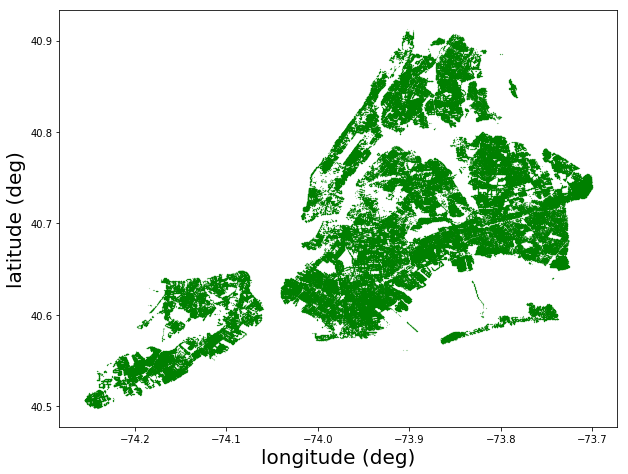

In [46]:
ax = treegpd.plot(markersize=0.01, color='green', figsize=(10,10))
ax.set_ylabel("latitude (deg)", fontsize=20)
ax.set_xlabel("longitude (deg)", fontsize=20);

In [47]:
#number of trees across zipcode
ntrees = treegpd.groupby("zipcode").count().reset_index()[["zipcode", "geometry"]].rename(
    columns={'geometry': 'ntrees'})
ntrees['zipcode'] = ntrees.zipcode.astype(int)
ntrees

,zipcode,ntrees
0,83,620
1,10001,173
2,10002,730
3,10003,560
4,10004,99
5,10005,112
6,10006,31
7,10007,276
8,10009,569
9,10010,431


## New York by ZIP CODE

In [48]:
# downloading a zipped file
!curl -O https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1342k    0 1342k    0     0  1321k      0 --:--:--  0:00:01 --:--:-- 1321k
100 1478k    0 1478k    0     0  1371k      0 --:--:--  0:00:01 --:--:-- 1371k


In [49]:
import zipfile
with zipfile.ZipFile("YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20_filename=ZIP_CODE_040114.zip","r") as zip_ref:
    zip_ref.extractall("zip")

In [50]:
zipsNYC = gpd.GeoDataFrame.from_file('ZIP_CODE_040114.shp')
zipsNYC.crs = from_epsg(2263) 
zipsNYC.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [51]:
zipsNYC.ZIPCODE = zipsNYC.ZIPCODE.astype(int)